# Comparative geometric mean returns

We focus mathematically on geometric mean returns since they 
optimally express mean-variance under logarithmic utility.
However, for visualization, we use boxplots
to see the persistence of returns.

Accuracy has been improved by using our research on
Gaussian mixtures presented in https://git.io/gmix --
specifically, our function gemrat() computes the geometric mean
rate by taking into account the fourth central moment, kurtosis.
This is crucial for *leptokurtotic* ("fat-tailed") assets.

We examine some long-term economic and financial time series,
then use Holt-Winters to forecast one-year ahead
as a generic way to illustrate future expected returns.
Daily data for bonds, stocks, and gold is also analyzed.

[We shall cover portfolio optimization in another notebook.]

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
     
*CHANGE LOG*

    2017-06-21  Replace groupgeoret() by groupgemrat().
    2016-01-05  MAJOR REWRITE: use pattern from monthly and daily series
                   for new functions groupget, grouppc, groupgeoret.
                   Forecast print out replaced by preservable groupholtf.
                   Dictionary comprehension clarifies code.
    2016-01-03  Fix issue #2 with v4 and p6 upgrades.
    2015-05-26  Code revision using template v14.12.21.
    2014-10-11  Code review. Template 2014-09-28.
    2014-09-01  First version.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223d :: Settings and system details
from __future__ import absolute_import, print_function, division
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.13
 ::  IPython 5.1.0
 ::  jupyter_core 4.2.1
 ::  notebook 4.1.0
 ::  matplotlib 1.5.1
 ::  numpy 1.11.0
 ::  scipy 0.17.0
 ::  sympy 1.0
 ::  pandas 0.19.2
 ::  pandas_datareader 0.2.1
 ::  Repository: fecon235 v5.17.0603 devPrtfBoltzmann
 ::  Timestamp: 2017-06-22T07:29:17Z
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


## Download data and construct a dataframe

We retrieve the following data of monthly frequency: **(aggregated) inflation, 
bonds (zero coupon equivalent of 10-y Treasury), equities (S&P 500), and 
gold (London PM fix)** -- all denominated in US dollars -- **then lastly, the 
real trade-weighted USD index (Federal Reserve) and US home prices (per Case-Shiller).** 
The details for each series is given in their respective notebooks. 
If the available data has daily frequency, we use the pandas method called 
"resampling" to induce monthly data (enter "monthly??" in an 
input cell for more details).

ATTENTION: *The inclusion of home prices, unfortunately, will create a 3-month lag, 
due to their release cycle. Since this is a comparative study, 
other data will appear out-of-date, but this 
section is intended for long-term trends.* 
Second half of this notebook will examine more responsive daily data.

In [3]:
#  Specify monthly series of interest as a dictionary:
msdic = {'Infl' : m4infl, 'Zero10' : m4zero10, 'SPX' : m4spx, 
         'XAU' : m4xau, 'USD' : m4usdrtb, 'Homes' : m4homepx }

#  Download data into a dataframe:
msdf = groupget( msdic )
#     "groupget??" at input cell gives function details.

 ::  Case-Shiller prepend successfully goes back to 1987.
 ::  S&P 500 prepend successfully goes back to 1957.


After downloading the level series, we compute the YoY percentage change 
for each series. *This will be the a trailing 12-month statistic, 
thus it is overlapping.*

In [4]:
#  Construct the mega YoY dataframe:
mega = grouppc( msdf, freq=12 )

### Define start time and get stats

In [5]:
#  Define start time as t0
t0 = '1988'

#  We can easily rerun the rest of this notebook 
#  by specifying another start time, then: Cell > Run All Below

In [6]:
#  Slice the data:
stats( mega[t0:] )

            Homes        Infl         SPX         USD         XAU      Zero10
count  351.000000  351.000000  351.000000  351.000000  351.000000  351.000000
mean     3.975145    2.360919    8.508886    0.158315    4.673031    2.191734
std      7.809477    1.005195   15.994362    5.224617   15.253308    7.260916
min    -18.906156   -0.186792  -42.349361  -10.650136  -27.752361  -18.521264
25%     -0.858003    1.659338    2.012961   -3.493227   -6.812520   -2.964638
50%      4.854246    2.324056   10.320474    0.064795    1.898076    2.855624
75%     10.490481    2.762071   19.324933    3.220781   13.886439    7.601522
max     17.077118    5.243615   52.051354   14.447233   60.357143   20.492399

 ::  Index on min:
Homes    2009-01-01
Infl     2009-07-01
SPX      2009-03-01
USD      2008-03-01
XAU      2013-12-01
Zero10   1994-10-01
dtype: datetime64[ns]

 ::  Index on max:
Homes    2004-07-01
Infl     1990-10-01
SPX      2010-03-01
USD      2009-03-01
XAU      2006-05-01
Zero10   1996-01

- There is not much correlation among our assets, 
  except a mild negative between gold XAU and USD. 
  (2015-05-26 at -0.51)

- The difference between the maximum and minimum percentage change
  for each item is remarkable. The index for maximum and minimum
  quickly gives us the historical epoch.
  
- The indexes of the minimums for Homes and SPX show the worst
  from the Great Recession was over by 2009-Q1.

## Boxplot of overlapping annual changes

The boxplot gives us an idea of the range of annual returns, 
and their ***persistence due to overlap***.
Thus trends can be discerned.
For example, if the blue box is located above zero,
then the bulk of returns is positive, and we can
expect the median, arithmetic, and geometric rates to be positive.
Returns outside the box, especially the notches,
perhaps could indicate unusual market conditions
or just plain data entry errors.

It is also a visual aid for the geometric mean returns 
which is most significant as an investment metric.
What appears as outliers may be due to leptokurtosis.

As usual, the ***red line*** indicates the *median*, but 
the **red dot** represents the *latest point*.

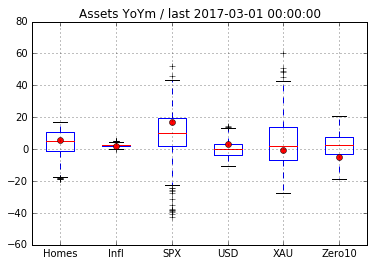

 ::  Finished: boxplot-Assets_YoYm.png


In [7]:
#  Overlapping YoY percentage change:
boxplot(mega[t0:], 'Assets YoYm')
#  where the red dot represents the latest point.

*Red dot outside the mid-range box alerts us to unusual conditions.* 
Attention should also be paid to the extreme value "slash" marks 
(where outliers are also revealed).


## Geometric mean returns on non-overlapping periods

David E. Shaw, famous for his proprietary hedge fund, remarked that 
one of the most important equations in finance is the penalization 
of arithmetic mean by one-half of variance:

$ g = \mu - (\sigma^2 / 2) $

which turns out to be a second-order approximation of geometric mean return.
It is good enough to maximize, instead of considering 
intricate mean-variance trade-offs.
We find it useful also as a metric for economic variables.

Many assets have leptokurtotic returns ("fat-tails") and so a better
approximation for the geometric mean rate is needed
which takes into account the fourth central moment called *kurtosis*.
Details are given on Gaussian mixtures in our research
at https://git.io/gmix 

The source code shows us that gemrat() first gives us 
the **geometric** mean return, followed by 
the **arithmetic mean return, volatility, and Pearson kurtosis**, 
then yearly frequency and sample size -- in list format.

In [8]:
#  How are we computing geometric mean returns?
#  Just add "?" or "??" to variables, procedures, etc.
#  to find out the details, e.g.

#  gemrat() is the user friendly version of gemrate()
#  which in turn relies on the following:

gemreturn_Jean??

Signature: gemreturn_Jean(mu_return, sigma, k_Pearson=3)
Source:   
def gemreturn_Jean( mu_return, sigma, k_Pearson=3 ):
    '''Approximation for geometric mean RETURN via Jean (1983) infinite series.
       Important definition: "financial return" := 1 + "rate"
       where rate is expressed in decimal form.
    '''
    #  Jean (1983) derived the exact infinite series for geometric mean return
    #  around a reference point (the arithmetic mean return worked out best).
    #  Here we code an approximation by the first five terms of that series:
    terms = [ np.log(mu_return), 0, 0, 0, 0 ]
    #  By stipulation, we shall ignore the odd moments...
    #  terms[1] = 0   # Zero by symmetry:  absolute first  central moment.
    #  terms[3] = 0   # Zero by symmetry:  absolute third  central moment.
    variance = sigma**2                 #  absolute second central moment.
    k_raw = k_Pearson * (sigma**4)      #  absolute fourth central moment.
    #       kurtosis details in kurtfun().


In [9]:
#  Geometric mean rates, non-overlapping, annualized:
groupgemrat( msdf[t0:], yearly=12 )
    
#  Note that we applied groupgemrat to msdf, not mega.
#  Generally gemrat requires price levels.
#  Note that groupgemrat is just gemrat() for group dataframes.

[[3.51, 3.54, 2.47, 4.06, 12, 350, 'Homes'],
 [2.29, 2.29, 0.49, 8.8, 12, 350, 'Infl'],
 [6.97, 7.72, 12.33, 10.53, 12, 350, 'SPX'],
 [0.22, 0.3, 4.14, 4.11, 12, 350, 'USD'],
 [2.41, 3.25, 12.93, 5.55, 12, 350, 'XAU'],
 [1.6, 1.84, 7.04, 5.68, 12, 350, 'Zero10']]

The first element in each list gives us the geometric mean rate.
They should be compared with the respective median rates previously computed.

The fourth element in each list gives us the kurtosis statistic
where 3.0 is theoretically expected if a distribution is Gaussian.

Even home prices have slightly fat tails.
The equities market shows the highest level of leptokurtosis.

Kurtosis is generally observed to increase when the
frequency of data is increased.

#### Note: the geometric mean rates do not include interest and dividend payouts for bonds and equities. 

Some observations in chronological order:

 - 2014-10-12, georet since 1988
    - Inflation in the long-run about 3% annually.
    - Bond price alone increases 2% annually (excludes interest income).
    - Gold at 1.73% does not keep up with inflation.
    - USD at break-even over the long-run.
    - Home prices have georet of 3.6%.


- 2015-05-27, georet since 1988
    - Inflation in the long-run drops 70 bp to about 2.3% annually.
    - Bond price continues its increase at 2% annually.
    - Gold at 3.4% reacting more to stronger USD (cf. correlation).
    - Home prices also have georet of 3.4% (but low 2.6% volatility).


- 2016-01-03, georet since 1988
    - Long-run inflation is 2.3% annually (Current Fed target: 2.0%).
    - Bond price increases at 2% annually (but Fed has just hiked rates!).
    - Equities at robust 7.6% annually (but ZIRP is finished).
    - Gold moving along at 2.9% (reflecting horrible 2015 year).
    - Nominal home prices at steady 3.4% per annum.


- 2017-06-18, gemrat since 1988
    - Long-run inflation is 2.3% annually (Current Fed target: 2.0%).
    - Bond price increases at 1.6% annually (Fed Funds range: 100-125 bp).
    - Equities at robust 6.97% annually.
    - Gold stagnating at 1.6%.
    - Nominal home prices at steady 3.5% per annum.     

# Forecasts using Holt-Winters method

We forecast one-year ahead using the monthly data
and Holt-Winters with default parameters
(which could be optimized for each individual time-series).

Note that the most current inflation level is rebased to 1, 
thus 1.02 would signify 2% increase.

In [10]:
#  These 12-periods ahead forecasts use default alpha and beta values
#  found empirically to be optimal for a fixed Kalman filter.

groupholtf( msdf, h=12 )

            Homes      Infl          SPX         USD          XAU     Zero10
0   237048.401009  0.998722  2368.060000  100.605000  1232.400000  80.109472
1   236335.064020  1.002023  2350.768764  101.934254  1242.502863  80.713012
2   237617.243053  1.003772  2380.922547  102.284994  1239.653418  80.124459
3   238899.422086  1.005521  2411.076329  102.635734  1236.803973  79.535906
4   240181.601120  1.007270  2441.230111  102.986473  1233.954528  78.947353
5   241463.780153  1.009020  2471.383894  103.337213  1231.105083  78.358800
6   242745.959186  1.010769  2501.537676  103.687953  1228.255638  77.770247
7   244028.138219  1.012518  2531.691459  104.038693  1225.406193  77.181694
8   245310.317252  1.014267  2561.845241  104.389432  1222.556749  76.593141
9   246592.496286  1.016016  2591.999023  104.740172  1219.707304  76.004588
10  247874.675319  1.017765  2622.152806  105.090912  1216.857859  75.416035
11  249156.854352  1.019514  2652.306588  105.441651  1214.008414  74.827482

### Forecast log for monthly data

Changing Holt-Winters *alpha* from 0.20 to 0.10 varies the forecast only slightly. The important parameter is *beta* to capture trend effects. Currently we shall rely on default Holt-Winters settings for robustness.


- 2014-09-01, Twelve-month Forecasts given data through 2014-07-01:
    - Inflation at 1.44%.
    - 10-y Bonds price -6.7%, thus rate +75 bp given zero10dur. 
    - SPX +16.6% to 2280.
    - Gold tanks from 1286 to 1067. 
    - USD +1.4% broadly.


- 2014-10-11, Twelve-month Forecasts given ten-year data, robust HW:
    - Inflation at 1.9%
    - Zero10 indicates slight downward pressure on interest rates.
    - SPX to 2239, but market seems skeptical.
    - Gold tanks to 1184 (region which we have seen just recently).
    - USD definitely has an upward bias against all FX, even NZD and AUD.
    - Home prices looking to increase from \$203K to \$220K 


- 2015-05-28, Twelve-month Forecasts given data through 2015-03-01, robust HW:
    - Inflation at 0.5% (which seems dramatic).
    - Zero10 price increases by 8.92%, thus 10-year rate decreases by 100 bp.
    - SPX to 2322, but no metric says it's fair valued.
    - Gold to 1130, which would break support.
    - USD very strong, up 12% globally (QE-EU started, and possible Grexit).
    - Home prices looking to increase from \$214K to \$223K


- 2016-01-03, Twelve-month Forecasts given data through 2015-10-01, robust HW:
    - Inflation at 1.1% (still below Fed target, see https://git.io/fed)
    - Bonds and equities, forecasting Zero10 and SPX, will be flat.
    - Gold to continue down trend, expected to fall to \$941 in a year.
    - USD 10% higher in light of divergence between Fed hike(s) and ECB QE.
    - Home prices expected to be flat (but watch mortgage spreads).


- 2017-06-18, Twelve-month Forecasts given data through 2017-03-01, robust HW:
    - Inflation at 2.1% (to slightly exceed Fed target of 2.0%)
    - Bonds: Zero10 price to decline -7.3%, so higher bond rates.
    - SPX to climb higher by +13.3%.
    - Gold expected to fall to \$1211 in a year.
    - USD 5.2% higher in light of higher expected interest rates.
    - Home prices expected higher by 5.7% (some regions are over-bid).

# DAILY DATA, including major FX

We examine bonds (zero coupon equivalent of 10-y Treasury), 
equities (SPX), gold (XAU), EURUSD, and USDJPY 
at higher frequency (daily) for the most recent developments. 

We skip: *inflation and the real trade-weighted USD index 
which have a slow monthly release schedule. 
As for US home price data, there is a three month lag.* 

In [11]:
#  Specify daily series of interest as a dictionary
#  where key is name, and value is its data code:
dsdic = { 'Zero10' : d4zero10, 'SPX' : d4spx, 'XAU' : d4xau, 
          'EURUSD' : d4eurusd, 'USDJPY' : d4usdjpy }

In [12]:
#  Download data into a dataframe:
dsdf = groupget( dsdic )

 ::  S&P 500 prepend successfully goes back to 1957.


In [13]:
#  Construct the dega YoY percent dataframe:
dega = grouppc( dsdf, freq=256 )
#                         ^for daily data

In [14]:
#  Set the start date for daily series:
u0 = '2010-01-01'

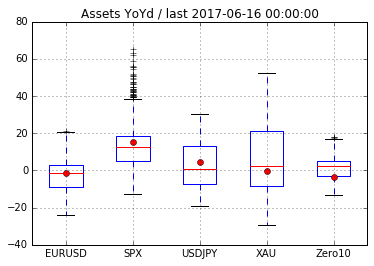

 ::  Finished: boxplot-Assets_YoYd.png


In [15]:
#  Plot overlapping percentage changes:
boxplot( dega[u0:], 'Assets YoYd' )

#  Note that the "last" timestamp will be more
#  recent than for the monthly series.

Although monthly data is more suitable for making long-term forecasts, 
daily data is more sensitive to immediate market perturbations. 

2016-01-03  Good example of the foregoing remark is the 
reaction in the overall market due to the first Fed rate hike 
in almost a decade on 2015-12-16. ZIRP, zero interest rate program, 
has been terminated, along with US quantitative easing, 
thus asset prices must adjust to financing constraints. 
Note how equities and gold are now below their mid-range boxes.

2017-06-18  Only Zero10 is below its mid-range box,
due to recent Fed rate hikes.
The upper outliers for the SPX is quite remarkable.

In [16]:
stats(dega[u0:])

            EURUSD          SPX       USDJPY          XAU       Zero10
count  1946.000000  1946.000000  1946.000000  1946.000000  1946.000000
mean     -2.821745    12.635400     2.690537     4.866887     1.581339
std       8.339085    10.355696    12.015074    17.209174     6.139394
min     -23.984762   -12.887678   -19.052589   -29.210332   -13.248728
25%      -8.763417     5.018106    -7.332421    -8.333041    -2.880033
50%      -1.567266    12.417470     0.733089     2.222734     2.244734
75%       2.985455    18.454224    13.279215    21.337671     5.178653
max      21.056554    65.300874    30.357599    52.361809    18.075299

 ::  Index on min:
EURUSD   2015-03-11
SPX      2016-02-11
USDJPY   2016-08-02
XAU      2013-12-26
Zero10   2010-01-07
dtype: datetime64[ns]

 ::  Index on max:
EURUSD   2011-06-06
SPX      2010-03-02
USDJPY   2013-05-28
XAU      2011-09-06
Zero10   2012-02-01
dtype: datetime64[ns]

 ::  Head:
              EURUSD        SPX    USDJPY        XAU     Zero10
T

- 2015-05-29, Suprisingly, very little correlation between EURUSD and USDJPY: -6%. Gold appears more correlated with USDJPY at -87% than EURUSD at +6%

- 2016-01-05, Given the latest Fed hike, the correlation to watch is between equities and bonds (-0.69 SPX and Zero10).

- 2017-06-18, Gold less correlated with USDJPY at -80%. Those expecting a sharp stock market decline are long bonds as a hedge, correlation at -61%.

In [17]:
#  What are the latest daily prices?
tail( dsdf )

            EURUSD      SPX  USDJPY      XAU     Zero10
T                                                      
2017-06-08  1.1217  2433.79  110.10  1273.10  82.266927
2017-06-09  1.1190  2431.77  110.61  1266.55  82.121206
2017-06-12  1.1204  2429.39  109.72  1266.40  82.121206
2017-06-13  1.1194  2440.35  110.12  1262.00  82.121206
2017-06-14  1.1277  2437.92  109.16  1275.50  82.559190
2017-06-15  1.1152  2432.46  110.66  1254.55  82.486022
2017-06-16  1.1194  2433.15  110.84  1255.40  82.486022

In [18]:
#  Geometric mean rates, non-overlapping, annualized:
groupgemrat( dsdf[u0:], yearly=256 )

[[-3.72, -3.25, 9.41, 4.52, 256, 1945, 'EURUSD'],
 [9.18, 10.27, 15.02, 7.76, 256, 1945, 'SPX'],
 [1.81, 2.3, 9.88, 6.65, 256, 1945, 'USDJPY'],
 [0.32, 1.89, 16.93, 9.17, 256, 1945, 'XAU'],
 [1.71, 1.96, 7.2, 4.1, 256, 1945, 'Zero10']]

### Closing remarks on daily data

- 2014-10-11, Really near-term picture is too bright for SPX while XAU looks dark. Sell stocks, and start to accumulate gold.


- 2015-05-28, XAU georet changed from 2.6% to 1.6%. Zero10 monthly forecast is basically unchanged. Real rate is what matters for gold. USD stronger by 4.8% against both the EUR and JPY.


- 2016-01-03, XAU georet changed from 1.6% to -0.41%, commodities including oil going through a bear market. Bonds have not sold off despite 2015-12-16 Fed rate hike, probably due to world appetite for USD which is stronger by about 4.3% against EUR and JPY. SPX looks vulnerable given the past maxims about rate hikes, but the Fed is actually still very accomodative.


- 2017-06-18, XAU gemrat appears stagnant at 0.44%. SPX still looks vulnerable given recent rate hikes, but the Fed is still accomodative despite very low unemployment. Bonds are set to accept money flow when the stock market tanks.